In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import time
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML

%tensorflow_version 2.x
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dropout

TensorFlow 2.x selected.


In [0]:
def normalize_value(val, max_val, min_val):
    '''
        The returns the normalized version of an value, given
        the maximum value and minimum value in the data_column

        Using formula:

        Norm value = (x_i - (a+b)/2) / ((a-b)/2)
    '''
    return (val - (max_val + min_val)/2) / ((max_val - min_val)/2)

def normalize_data(X_train, X_test):
    '''
        Normalizes the dataset to (-1, to 1); and uses ranges from the training
        data, to normalize the testing data.
    '''

    X_train_normalized = X_train[:, 0] # the first columns are just ones for constants
    X_test_normalized = X_test[:, 0]

    for i in range(1, X_train.shape[1]):
        max_val = np.max(X_train[:, i])
        min_val = np.min(X_train[:, i])

        col_normalized_train = [normalize_value(val, max_val, min_val) for val in X_train[:, i]] 
        col_normalized_test = [normalize_value(val, max_val, min_val) for val in X_test[:, i]]

        X_train_normalized = np.column_stack((X_train_normalized, col_normalized_train))
        X_test_normalized = np.column_stack((X_test_normalized, col_normalized_test))

    return X_train_normalized, X_test_normalized

def calc_msfe(y_actual, y_predictions):
    '''
        Calculates Mean Squared Forecast Error (MSFE) between the predicted and
        actual value.
    '''
    n = len(y_actual)
    errors = [(y_actual[i]-y_predictions[i])**2 for i in range(n)]
    return np.sum(errors)/n

def calc_historical_average_return_forecast(returns, num_out_sample):   
    '''
        Computes the historical average return forecast.
        The forecast is estimated as the average return of all the past time periods, as
        defined in teh equation above.
    '''
    forecasted_returns = [(np.sum(returns[:t])/t) for t in range(1, len(returns))]
    return forecasted_returns[((-1)*num_out_sample):]

def calc_r2_os(y_actual, y_predictions, benchmark_predictions):
    '''
        Computes the R2_os score for each model by comparing it with the MSFE of
        historical average return forecast
    '''
    msfe_i = calc_msfe(y_actual, y_predictions)
    msfe_0 = calc_msfe(y_actual, benchmark_predictions)
    return 1 - (msfe_i / msfe_0)

def calc_R2OS_and_p_value(e_HA, FC_HA, e_X, FC_X):
    # R2OS
    R2OS = 100*(1- (np.sum(np.power(e_X, 2)) / np.sum(np.power(e_HA, 2))))
    
    # P-value
    e_X_reshaped = e_X.reshape(e_X.shape[0], 1)
    FC_X_reshaped = FC_X.reshape(FC_X.shape[0], 1)
    f_i = np.power(e_HA, 2) - (np.power(e_X_reshaped,2) - np.power(FC_HA - FC_X_reshaped, 2))
    results_i  = sm.OLS(f_i, np.ones((f_i.shape[0], 1))).fit()
    results_i = results_i.get_robustcov_results(cov_type='HAC',maxlags=0)
    p_value = 1 - norm.cdf(results_i.tvalues[0], loc=0, scale=1)

    return R2OS, p_value

def plot_graphs(predictions, actual, n_holdout_sample, timestamps, title=''):
    # Compute 95% interval and median of the predicted values
    prediction_interval = np.percentile(predictions, axis=0, q=[2.5, 97.5])
    prediction_mean = np.mean(predictions, axis=0)
    prediction_mean = prediction_mean[n_holdout_sample:]

    plt.figure(figsize=(10, 8))
    plt.plot(timestamps, prediction_mean, label='mean forecasts', c='g')
    plt.plot(timestamps, prediction_interval[0,:][n_holdout_sample:], c='g', ls='--', label='upper bound')
    plt.plot(timestamps, prediction_interval[1,:][n_holdout_sample:], c='g', ls='--', label='lower bound')
    plt.plot(timestamps, actual, label='Actual returns', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(title)
    plt.legend()
    plt.show()

## Bayesian Linear Regression model

In [10]:
def initialize_blm():
    # The Stan model. Running this cell compiles the Stan model, which takes
    # some time

    stan_code_blm = """
    data {
        int<lower=0> n_var;       // Number of predictor variables

        int<lower=0> num_in_sample;  // The out of sample cut off point
        int<lower=0> num_out_sample;   // Number of predictions to generate
        
        // Knwon predictors
        matrix[num_in_sample, n_var] X_train;    // data matrix for training
        matrix[num_out_sample, n_var] X_test;    // data matrix for predictions and testing

        // Known log excess returns
        real y_train[num_in_sample];  // log-returns for trainings
        // real y_test[num_out_sample];   // log-returns from out of sample
        
        // Hyper parameters for priors
        real beta_mean;  // The mean hyperparameter for prior of betas
        real beta_std;  // The std hyperparameter for prior of betas
        real sigma_alpha;    // The mean hyperparameter for prior of sigma
        real sigma_beta;     // The std hyperparameter for prior of sigma
    }

    parameters {
        vector[n_var] beta; // Vector with coefficients for each variable
        // real sigma; // Std deviation for normal distribution, error parameter
        real<lower=0> sigma;
    }

    model {

        // beta ~ normal(beta_mean, beta_std);
        beta ~ student_t(1,0,2.5);
        // sigma ~ gamma(sigma_alpha, sigma_beta);

        for (i in 1:num_in_sample) {
            y_train[i] ~ normal(dot_product(beta, X_train[i]), sigma);
        }
    }

    // Generate the predicted function values for the next n_future steps.
    generated quantities {
        real y_pred[num_out_sample];

        // generating predictions
        for(t in 1:num_out_sample) {
            y_pred[t] = normal_rng(
                dot_product(beta, X_test[t]),
                sigma);
        }
    }
    """

    start = time.time() # timer started

    stan_model_blm = pystan.StanModel(model_code=stan_code_blm)

    print('Model Compiled')
    print('--'*20)
    print('Time taken: {0:.4f}s'.format(time.time() - start)) #timer ended

    return stan_model_blm

stan_model_blm = initialize_blm()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7143e238289ce76c63fe2853bfec495b NOW.


Model Compiled
----------------------------------------
Time taken: 63.5975s


In [0]:
def get_results_blm(X_stan, Y, fc_ha, 
                    n_in_sample, n_holdout_sample, n_out_sample, verbose=False):
    X_train = X_stan[:n_in_sample]
    X_test = X_stan[n_in_sample:]
    X_train_norm, X_test_norm = normalize_data(X_train, X_test)

    Y_train = Y[:n_in_sample]
    Y_test = Y[n_in_sample:]

    stan_data_blm = {
        'n_var': X_stan.shape[1],
        'num_in_sample': n_in_sample,
        'num_out_sample': n_out_sample,
        'X_train': X_train_norm,
        'X_test': X_test_norm,
        'y_train': Y_train,
        'y_test': Y_test,
        'beta_mean': 0,
        'beta_std': 10,
        'sigma_alpha': 0.5,
        'sigma_beta': 0.5
    } 

    start = time.time() # Timer started

    parameters = ['beta', 'sigma']
    results = stan_model_blm.sampling(data=stan_data_blm)
    
    if verbose:
        print('\nBayesian Linear Regression')
        print('==='*20)
        print(results.stansummary(pars=parameters))
        
    samples = results.extract()

    print('--'*20)
    print('Time taken: {0:.4f}s'.format(time.time() - start)) #timer ended

    predictions = samples['y_pred']
    
    # Calculating forecasting results
    output_dict = {
        'predictor': 'Bayesian Linear Regression',
        'R2OS': calc_r2_os(Y_test[n_holdout_sample:], 
                        np.mean(predictions, axis=0)[n_holdout_sample:], 
                        fc_ha),
        'MSFE': calc_msfe(Y_test[n_holdout_sample:], 
                        np.mean(predictions, axis=0)[n_holdout_sample:]),
        'predictions': predictions
    }

    if verbose:
        # Plotting graph
        

        # Compute 95% interval and median of the predicted values
        prediction_interval = np.percentile(predictions, axis=0, q=[2.5, 97.5])
        prediction_mean = np.mean(predictions, axis=0)
        prediction_mean = prediction_mean[n_holdout_sample:]

        plt.plot(prediction_mean, label='mean')
        plt.plot(prediction_interval[0,:][n_holdout_sample:], label='upper bound')
        plt.plot(prediction_interval[1,:][n_holdout_sample:], label='lower bound')
        plt.plot(Y[(n_in_sample + n_holdout_sample):])
        plt.legend()
        plt.show()

    return output_dict

## Autoregressive models

In [4]:
def initialize_ar_lag():
    stan_code_ar_lag = """
    data {

        int<lower=0> n_lag;       // Number of lags

        int<lower=0> num_out_sample;  // The out of sample cut off point
        int<lower=0> num_in_sample;       // Number of predictions to generate

        real y_train[num_in_sample];     // in-sample log-returns
        real y_test[num_out_sample];     // out-of-sample log-returns

        // Knwon predictors
        matrix[num_in_sample, n_lag] y_train_lag;    // data matrix for training
        matrix[num_out_sample, n_lag] y_test_lag;    // data matrix for predictions and testing

        real sigma_alpha;    // The alpha hyperparameter for prior of sigma
        real sigma_beta;     // The beta hyperparameter for prior of sigma
        real beta_mean;  // The mean hyperparameter for prior of betas
        real beta_std;  // The std hyperparameter for prior of betas
    }


    parameters {

        vector[n_lag] beta; // Vector with coefficients for each variable
        real<lower=0> sigma; // error term
        real alpha; // coefficient for constant
    }

    model {

        // beta ~ normal(beta_mean, beta_std);
        // sigma ~ gamma(sigma_alpha, sigma_beta);

        beta ~ student_t(1,0,2.5);

        for (i in 1:num_in_sample) {
            y_train[i] ~ normal(dot_product(beta, y_train_lag[i]) + alpha, sigma);
        }

    }

    // Generate the predicted function values for the next n_future steps.
    generated quantities {
        real y_pred[num_out_sample];

        // generating predictions
        for(t in 1:num_out_sample) {
            y_pred[t] = normal_rng(
                dot_product(beta, y_test_lag[t]) + alpha,
                sigma);
        }

    }
    """

    start = time.time() # timer started

    stan_model_ar_lag = pystan.StanModel(model_code=stan_code_ar_lag)

    print('Model Compiled')
    print('--'*20)
    print('Time taken: {0:.4f}s'.format(time.time() - start)) #timer ended

    return stan_model_ar_lag

stan_model_ar_lag = initialize_ar_lag()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc5e9023446a7c09a4a69d9e4e593d58 NOW.


Model Compiled
----------------------------------------
Time taken: 66.4171s


In [0]:
def get_results_ar_lag(Y, n_lag, n_in_sample, n_holdout_sample, n_out_sample, fc_ha, verbose=False):

    Y_train = Y[n_lag:n_in_sample]
    Y_test = Y[n_in_sample:]

    if n_lag == 1:
        y_train_lag = Y[:(n_in_sample-1)].reshape(-1, 1)
        y_test_lag = Y[n_in_sample-1:-1].reshape(-1, 1)
    else:
        y_train_lag = np.column_stack((Y[1:(n_in_sample-1)], Y[:(n_in_sample-2)]))
        y_test_lag = np.column_stack((Y[n_in_sample-1:-1], Y[n_in_sample-2:-2]))

    stan_data_ar_lag = {
        'n_lag': n_lag,
        'num_in_sample': n_in_sample - n_lag,
        'num_out_sample': n_out_sample,
        'y_train_lag': y_train_lag,
        'y_test_lag': y_test_lag,
        'y_train': Y_train,
        'y_test': Y_test,
        'beta_mean': 0,
        'beta_std': 10,
        'alpha_mean': 0,
        'alpha_std': 2,
        'sigma_alpha': 0.5,
        'sigma_beta': 1
    } 

    start = time.time() # Timer started

    parameters = ['beta', 'sigma', 'alpha']
    results_ar_lag = stan_model_ar_lag.sampling(data=stan_data_ar_lag)
    
    if verbose:
        print('\nAuto Regression with lag {0}'.format(n_lag))
        print('==='*20)
        print(results_ar_lag.stansummary(pars=parameters))
    
    samples_ar_lag = results_ar_lag.extract()

    print('--'*20)
    print('Time taken: {0:.4f}s'.format(time.time() - start)) #timer ended

    predictions = samples_ar_lag['y_pred']

    # Calculating forecasting results
    output_dict = {
        'predictor': 'AR lag {0}'.format(n_lag),
        'R2OS': calc_r2_os(Y_test[n_holdout_sample:], 
                        np.mean(predictions, axis=0)[n_holdout_sample:], 
                        fc_ha),
        'MSFE': calc_msfe(Y_test[n_holdout_sample:], 
                        np.mean(predictions, axis=0)[n_holdout_sample:]),
        'predictions': predictions
    }

    if verbose:
        # Plotting graph

        # Compute 95% interval and median of the predicted values
        prediction_interval = np.percentile(predictions, axis=0, q=[2.5, 97.5])
        prediction_mean = np.mean(predictions, axis=0)
        prediction_mean = prediction_mean[n_holdout_sample:]

        plt.plot(prediction_mean, label='mean')
        plt.plot(prediction_interval[0,:][n_holdout_sample:], label='upper bound')
        plt.plot(prediction_interval[1,:][n_holdout_sample:], label='lower bound')
        plt.plot(Y[(n_in_sample + n_holdout_sample):])
        plt.legend()
        plt.show()

    return output_dict

## BLM with Auto-regression

In [6]:
def initialize_blm_ar():
    stan_code_blm_ar = """
    data {

        int<lower=0> n_var;       // Number of predictor variables
        int<lower=0> n_lag;        // Number of lags

        int<lower=0> num_in_sample;  // The out of sample cut off point
        int<lower=0> num_out_sample;   // Number of predictions to generate
        
        // Knwon predictors
        matrix[num_in_sample, n_var] X_train;    // data matrix for training
        matrix[num_out_sample, n_var] X_test;    // data matrix for predictions and testing

        // Knwon predictors
        matrix[num_in_sample, n_lag] y_train_lag;    // data matrix for training
        matrix[num_out_sample, n_lag] y_test_lag;    // data matrix for predictions and testing

        // Known log excess returns
        real y_train[num_in_sample];  // log-returns for trainings
        //real y_test[num_out_sample];   // log-returns from out of sample
        
        // Hyper parameters for priors
        // beta are the ceofficients of the predictors
        real beta_mean;  // The mean hyperparameter for prior of betas
        real beta_std;  // The std hyperparameter for prior of betas
        
        // sigma is the standard deviation
        real sigma_alpha;    // The alpha hyperparameter for prior of sigma
        real sigma_beta;     // The beta hyperparameter for prior of sigma
        
        // Hyper parameters for alpha (coefficients of auto-regressive part)
        real alpha_mean; 
        real alpha_std;
    }

    parameters {

        vector[n_var] beta;
        vector[n_lag] alpha;
        // real sigma;
        real<lower=0> sigma;
    }


    model {

        //beta ~ normal(beta_mean, beta_std);
        //alpha ~ normal(alpha_mean, alpha_std);
        //sigma ~ gamma(sigma_alpha, sigma_beta);

        beta ~ student_t(1,0,2.5);
        alpha ~ student_t(1, 0, 2.5);
        


        for (i in 1:num_in_sample) {
            y_train[i] ~ normal(dot_product(beta, X_train[i]) + dot_product(alpha, y_train_lag[i]), sigma);
        }
    }

    // Generate the predicted function values for the next n_future steps.
    generated quantities {
        real y_pred[num_out_sample];
        
        for(t in 1:num_out_sample) {
            y_pred[t] = normal_rng(
                dot_product(beta, X_test[t]) + dot_product(alpha, y_test_lag[t]),
                sigma);
        }
    }
    """
    start = time.time() # Timer started

    stan_model_blm_ar = pystan.StanModel(model_code=stan_code_blm_ar)

    print('--'*20)
    print('Model compiled')
    print('Time taken: {0:.4f}s'.format(time.time() - start)) #timer ended

    return stan_model_blm_ar

stan_model_blm_ar = initialize_blm_ar()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_841228a7a9e9598d3cf788a74b9801b0 NOW.


----------------------------------------
Model compiled
Time taken: 62.8880s


In [0]:
def get_results_blm_ar_lag(X_stan, Y, fc_ha, n_lag,
                    n_in_sample, n_holdout_sample, n_out_sample, verbose=False):
    

    if n_lag == 1:
        y_train_lag = Y[:(n_in_sample-1)].reshape(-1, 1)
        y_test_lag = Y[n_in_sample-1:-1].reshape(-1, 1)
    else:
        y_train_lag = np.column_stack((Y[1:(n_in_sample-1)], Y[:(n_in_sample-2)]))
        y_test_lag = np.column_stack((Y[n_in_sample-1:-1], Y[n_in_sample-2:-2]))
    
    X_train = X_stan[n_lag:n_in_sample]
    X_test = X_stan[n_in_sample:]
    X_train_norm, X_test_norm = normalize_data(X_train, X_test)

    Y_train = Y[n_lag:n_in_sample]
    Y_test = Y[n_in_sample:]

    stan_data_blm_ar = {
        'n_var': X_stan.shape[1],
        'n_lag': n_lag,
        'num_in_sample': n_in_sample-n_lag,
        'num_out_sample': n_out_sample,
        'y_train_lag': y_train_lag,
        'y_test_lag': y_test_lag,
        'X_train': X_train_norm,
        'X_test': X_test_norm,
        'y_train': Y_train,
        'y_test': Y_test,
        'beta_mean': 0,
        'beta_std': 10,
        'alpha_mean': 0,
        'alpha_std': 5,
        'sigma_alpha': 0.5,
        'sigma_beta': 0.5
    } 

    start = time.time() # Timer started

    parameters = ['beta', 'sigma', 'alpha']
    results = stan_model_blm_ar.sampling(data=stan_data_blm_ar)
    
    if verbose:
        print('\nBayesian Linear Regression with AR lag {0}'.format(n_lag))
        print('---'*20)
        print(results.stansummary(pars=parameters))
    
    samples = results.extract()

    print('--'*20)
    print('Time taken: {0:.4f}s'.format(time.time() - start)) #timer ended


    # Plotting graph
    predictions = samples['y_pred']

    # Calculating forecasting results
    output_dict = {
        'predictor': 'BLM with AR lag {0}'.format(n_lag),
        'R2OS': calc_r2_os(Y_test[n_holdout_sample:], 
                        np.mean(predictions, axis=0)[n_holdout_sample:], 
                        fc_ha),
        'MSFE': calc_msfe(Y_test[n_holdout_sample:], 
                        np.mean(predictions, axis=0)[n_holdout_sample:]),
        'predictions': predictions
    }

    if verbose:

        # Compute 95% interval and median of the predicted values
        prediction_interval = np.percentile(predictions, axis=0, q=[2.5, 97.5])
        prediction_mean = np.mean(predictions, axis=0)
        prediction_mean = prediction_mean[n_holdout_sample:]

        plt.plot(prediction_mean, label='mean')
        plt.plot(prediction_interval[0,:][n_holdout_sample:], label='upper bound')
        plt.plot(prediction_interval[1,:][n_holdout_sample:], label='lower bound')
        plt.plot(Y[(n_in_sample + n_holdout_sample):])
        plt.legend()
        plt.show()

    return output_dict

## Driver function for generating results from all the stan models

In [0]:
def generate_stan_results(Y, X_stan, FC_HA, 
                          n_in_sample, n_holdout_sample, 
                          n_forecast_evaluation, n_out_sample,verbose=False):

    # Running stan models and getting prediction results
    # results_stan = {
    #     'blm': get_results_blm(X_stan, Y, FC_HA, 
    #                                     n_in_sample, n_holdout_sample, n_out_sample, verbose)
    # }

    results_stan = {
        'blm': get_results_blm(X_stan, Y, FC_HA, 
                                        n_in_sample, n_holdout_sample, n_out_sample, verbose),
        'ar_lag_1': get_results_ar_lag(Y, 1, n_in_sample, n_holdout_sample, n_out_sample, FC_HA, verbose),
        'ar_lag_2': get_results_ar_lag(Y, 2, n_in_sample, n_holdout_sample, n_out_sample, FC_HA, verbose),
        'blm_ar_lag_1': get_results_blm_ar_lag(X_stan, Y, FC_HA, 1, n_in_sample, 
                                                    n_holdout_sample, n_out_sample, verbose),
        'blm_ar_lag_2': get_results_blm_ar_lag(X_stan, Y, FC_HA, 2, n_in_sample, 
                                                    n_holdout_sample, n_out_sample, verbose)
    }

    
    
    # Calculating R2OS error scores as well as p-value
    actual = np.reshape(Y[n_in_sample + n_holdout_sample :], (Y[n_in_sample + n_holdout_sample:].shape[0], 1))
    
    FC_HA = calc_historical_average_return_forecast(Y, n_out_sample)
    FC_HA = FC_HA[n_holdout_sample:]
    FC_HA = np.array(FC_HA).reshape(-1, 1)

    e_HA = actual - FC_HA

    for results in results_stan:
        FC_MODEL = np.mean(results_stan[results]['predictions'], axis=0)
        FC_MODEL = FC_MODEL[n_holdout_sample:].reshape(-1, 1)
        e_MODEL = np.kron(np.ones((1, FC_MODEL.shape[1])), actual) - FC_MODEL
        
        R2OS_percentage, p_value = calc_R2OS_and_p_value(e_HA, FC_HA, e_MODEL[:,0], FC_MODEL[:,0])
        results_stan[results]['R2OS_percentage'] = R2OS_percentage
        results_stan[results]['p_value'] = p_value

    arr_R2OS = []
    arr_R2OS_per = []
    arr_p_values = []
    # arr_models = ['Bayesian Linear Regression', 'AR lag 1', 'AR lag 2', 'BLR with AR Lag 1', 'BLR with AR Lag 2']
    arr_models = []
    arr_outside_ci = []
    arr_msfe = []

    for results in results_stan:
        arr_models.append(results_stan[results]['predictor'])
        arr_R2OS.append(results_stan[results]['R2OS'])
        arr_R2OS_per.append(results_stan[results]['R2OS_percentage'])
        arr_p_values.append(results_stan[results]['p_value'])

        # Calculating % of actual returns outside of the predicted range
        predictions = results_stan[results]['predictions']
        conf_int = np.percentile(predictions,  [2.5,97.5], axis=0)[:, n_holdout_sample:]

        num_outside = 0
        for i in range(len(actual)):
            if not(actual[i] > conf_int[0, i] and actual[i] < conf_int[1, i]):
                num_outside += 1
        arr_outside_ci.append(100 * num_outside/len(actual))
        arr_msfe.append(calc_msfe(actual, np.mean(predictions, axis=0)[n_holdout_sample:]))
        print(arr_msfe)


    df_stan = pd.DataFrame({
        'Models': arr_models,
        'MSFE': arr_msfe,
        'R2OS': arr_R2OS,
        'R2OS%': arr_R2OS_per,
        'p_values': arr_p_values,
        'Data outside of 95% interval (%)': arr_outside_ci
    })


    return {
        'results_stan': results_stan,
        'df_stan': df_stan,
        'actual': actual
    }

## Model training on NYSE data (1926 to 2010) that was used in Rapach et al. (2013)



Bayesian Linear Regression
Inference for Stan model: anon_model_7143e238289ce76c63fe2853bfec495b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%     50%     75%  97.5%  n_eff   Rhat
beta[1]    -0.02  2.7e-4   0.01  -0.05  -0.03   -0.02   -0.02 8.1e-4   2363    1.0
beta[2]    -0.05  6.9e-4   0.04  -0.13  -0.08   -0.05   -0.03   0.02   2796    1.0
beta[3]     0.03  3.8e-4   0.02  -0.01   0.02    0.03    0.04   0.07   2870    1.0
beta[4]  -2.0e-3  4.1e-4   0.03  -0.05  -0.02 -1.8e-3    0.02   0.05   4201    1.0
beta[5]      0.1  6.8e-4   0.04   0.03   0.08     0.1    0.13   0.18   3123    1.0
beta[6]   5.9e-3  4.7e-4   0.03  -0.04  -0.01  5.6e-3    0.02   0.06   3176    1.0
beta[7]     0.05  4.6e-4   0.02 7.5e-3   0.04    0.05    0.07    0.1   2393    1.0
beta[8]    -0.05  6.5e-4   0.03  -0.12  -0.08   -0.05   -0.03 7.8e-3   2319    1.0
beta[9]    -0.03  5.9e-4   0.03  -0.

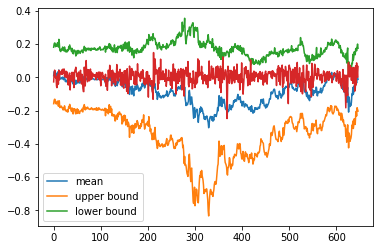


Auto Regression with lag 1
Inference for Stan model: anon_model_fc5e9023446a7c09a4a69d9e4e593d58.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.12  1.1e-3   0.07 -6.3e-3    0.08   0.12   0.16   0.25   3428    1.0
sigma     0.09  6.9e-5 3.9e-3    0.08    0.08   0.09   0.09   0.09   3221    1.0
alpha   3.2e-3  7.8e-5 5.5e-3 -7.7e-3 -5.6e-4 3.1e-3 7.0e-3   0.01   4967    1.0

Samples were drawn using NUTS at Wed Mar 25 19:05:41 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
----------------------------------------
Time taken: 5.4081s


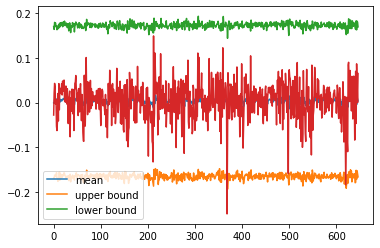


Auto Regression with lag 2
Inference for Stan model: anon_model_fc5e9023446a7c09a4a69d9e4e593d58.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.12  1.0e-3   0.07 -6.6e-3    0.08   0.12   0.17   0.25   4310    1.0
beta[2]  -0.02  1.0e-3   0.06   -0.15   -0.06  -0.02   0.03   0.11   4057    1.0
sigma     0.09  6.4e-5 4.0e-3    0.08    0.08   0.09   0.09   0.09   3795    1.0
alpha   3.0e-3  8.0e-5 5.7e-3 -8.3e-3 -8.6e-4 3.0e-3 6.8e-3   0.01   5106    1.0

Samples were drawn using NUTS at Wed Mar 25 19:05:46 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
----------------------------------------
Time taken: 5.5971s


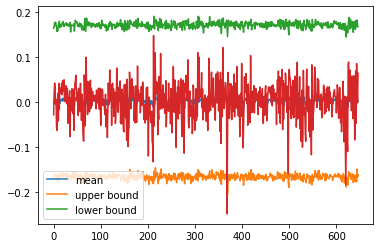


Bayesian Linear Regression with AR lag 1
------------------------------------------------------------
Inference for Stan model: anon_model_841228a7a9e9598d3cf788a74b9801b0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd    2.5%      25%    50%     75%   97.5%  n_eff   Rhat
beta[1]   -0.03  2.5e-4   0.01   -0.05    -0.04  -0.03   -0.02 -1.2e-3   2646    1.0
beta[2]   -0.13  8.4e-4   0.04   -0.21    -0.16  -0.13    -0.1   -0.05   2579    1.0
beta[3]    0.07  4.6e-4   0.02    0.03     0.06   0.07    0.09    0.12   2638    1.0
beta[4]  7.9e-3  4.0e-4   0.03   -0.04 -10.0e-3 7.7e-3    0.03    0.06   4289    1.0
beta[5]    0.15  7.5e-4   0.04    0.07     0.12   0.15    0.17    0.23   2766    1.0
beta[6]    0.03  5.0e-4   0.03   -0.02     0.01   0.03    0.05    0.08   2752    1.0
beta[7]    0.04  4.7e-4   0.02 -8.5e-3     0.02   0.04    0.05    0.08   2403    1.0
beta[8]   -0.04  6.8e-4   0.

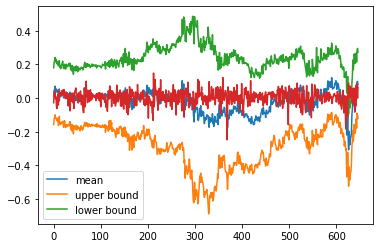


Bayesian Linear Regression with AR lag 2
------------------------------------------------------------
Inference for Stan model: anon_model_841228a7a9e9598d3cf788a74b9801b0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd    2.5%     25%    50%     75%   97.5%  n_eff   Rhat
beta[1]   -0.03  2.8e-4   0.01   -0.05   -0.04  -0.03   -0.02 -2.6e-3   2258    1.0
beta[2]   -0.13  8.4e-4   0.04   -0.21   -0.16  -0.13    -0.1   -0.04   2528    1.0
beta[3]    0.07  4.6e-4   0.02    0.02    0.06   0.07    0.09    0.12   2637    1.0
beta[4]    0.01  4.5e-4   0.03   -0.04 -7.5e-3   0.01    0.03    0.07   3621    1.0
beta[5]    0.15  7.9e-4   0.04    0.07    0.12   0.15    0.17    0.22   2621    1.0
beta[6]    0.03  5.3e-4   0.03   -0.02    0.01   0.03    0.05    0.09   2795    1.0
beta[7]    0.04  4.9e-4   0.02 -8.2e-3    0.02   0.04    0.05    0.08   2248    1.0
beta[8]   -0.04  7.2e-4   0.03    -0

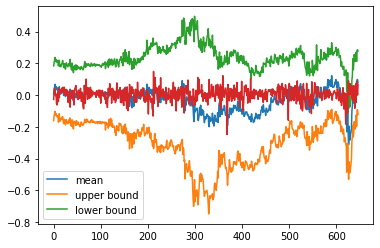

[0.01569581178930305]
[0.01569581178930305, 0.001852774193489152]
[0.01569581178930305, 0.001852774193489152, 0.0018532517200457131]
[0.01569581178930305, 0.001852774193489152, 0.0018532517200457131, 0.007039301523432689]
[0.01569581178930305, 0.001852774193489152, 0.0018532517200457131, 0.007039301523432689, 0.008103669951675389]





,Models,MSFE,R2OS,R2OS%,p_values,Data outside of 95% interval (%)
0,Bayesian Linear Regression,0.015696,-7.419964,-741.996435,0.499194,0.618238
1,AR lag 1,0.001853,0.006086,0.608564,0.043713,0.309119
2,AR lag 2,0.001853,0.005829,0.582948,0.043892,0.309119
3,BLM with AR lag 1,0.007039,-2.776209,-277.620914,0.894505,1.081917
4,BLM with AR lag 2,0.008104,-3.347186,-334.718593,0.870921,1.081917



Model forecasts of blm

------------------------------------------------------------


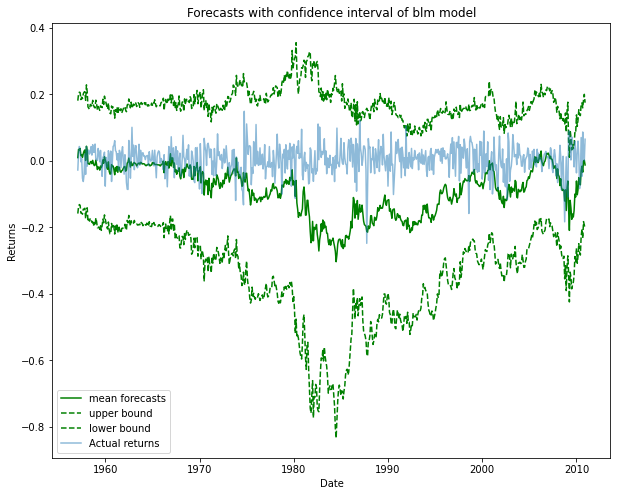


Model forecasts of ar_lag_1

------------------------------------------------------------


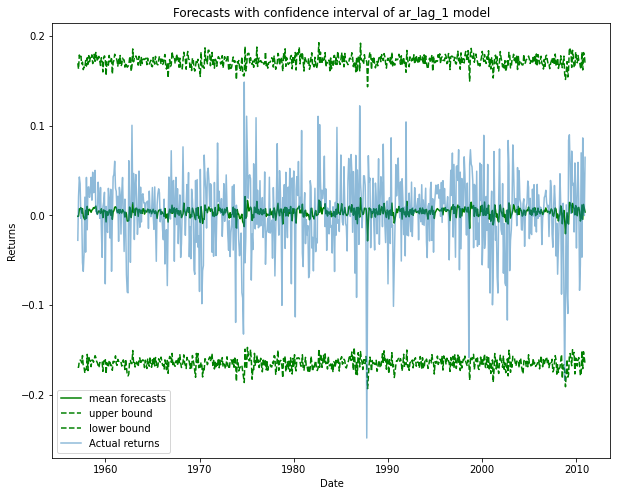


Model forecasts of ar_lag_2

------------------------------------------------------------


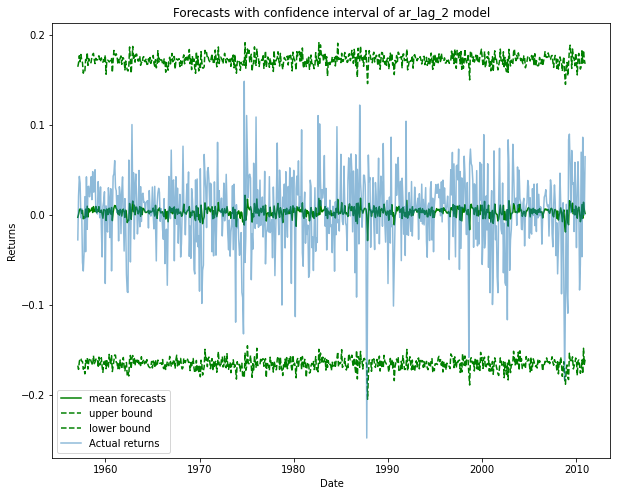


Model forecasts of blm_ar_lag_1

------------------------------------------------------------


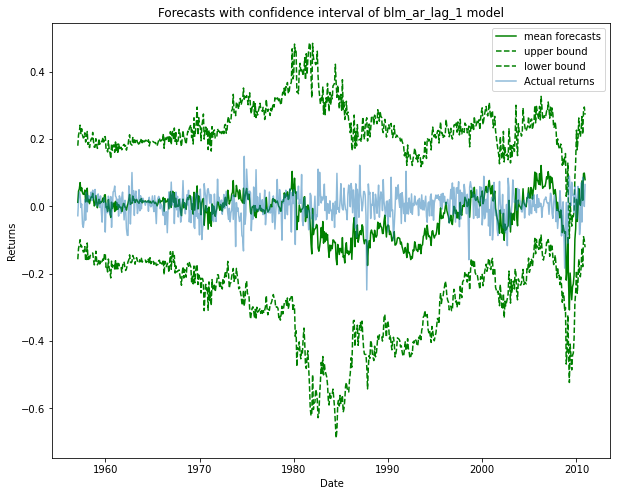


Model forecasts of blm_ar_lag_2

------------------------------------------------------------


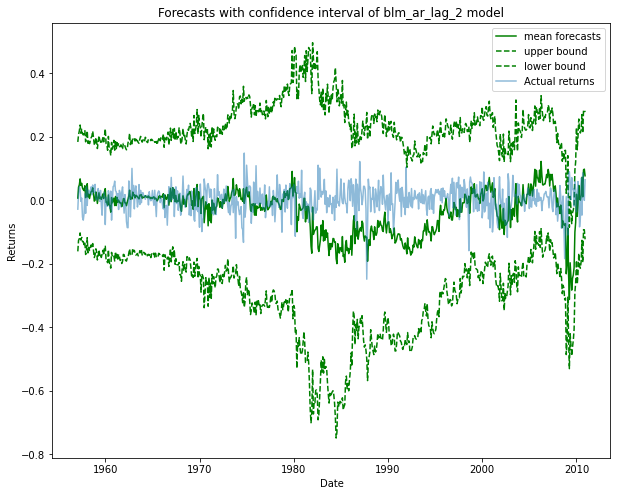

In [31]:
def generate_results_nyse_rapach_data(url_data, verbose=False):
    data = pd.read_excel(url_data, 'Monthly')
    data.head()

    # Equity premium


    idx_first = 671 # starting data 1926:11
    idx_last = 1679 # final date 2010:12

    timestamps = data.loc[idx_first:idx_last, 'Date (yyyymm)']

    market_return = np.array(data.loc[idx_first:idx_last, ['CRSP S&P 500 value-weighted return with dividends']]).flatten()
    r_f_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'Risk-free rate']) # risk free rate
    equity_premium = np.log(1+market_return)-np.log(1+r_f_lag) # log excess return

    #dividends
    d12=np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 dividends']) 
    #S7P 500 index
    sp500 = np.array(data.loc[idx_first:idx_last, 'S&P 500 index']) 
    # log dividend-price ratio
    dp = np.log(d12) - np.log(sp500) 
    # S&P 500 index, lagged 
    sp500_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'S&P 500 index']) # S&P 500 index, lagged 
    # log dividend yield
    dy = np.log(d12) - np.log(sp500_lag)
    # earnings
    e12 = np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 earnings'])
    # log earnings to price ratio
    ep = np.log(e12) - np.log(sp500)
    # log dividend-payout ratio
    de = np.log(d12) - np.log(e12)
    # volatility (SVAR)
    svar = np.array(data.loc[idx_first:idx_last, 'Monthly sum of squared daily returns on S&P 500 index'])
    # book to market ratio
    bm = np.array(data.loc[idx_first:idx_last, 'DJIA book-to-market value ratio'])
    # net equity issuing activity
    ntis=np.array(data.loc[idx_first:idx_last, 'Net equity expansion'])
    # t-bill raate
    tbl = np.array(data.loc[idx_first:idx_last, '3-month Treasury bill yield (secondary market)'])
    # long-term government bond yield
    lty = np.array(data.loc[idx_first:idx_last, 'Long-term government bond yield'])
    # long-term governmnent bond return
    ltr = np.array(data.loc[idx_first:idx_last, 'Long-term government bond return'])
    # term spread
    tms=lty-tbl
    # AAA-rated corporate bond yield
    aaa = np.array(data.loc[idx_first:idx_last, 'Moodys AAA-rated corporate bond yield'])
    # BAA-rated corporate bond yield
    baa = np.array(data.loc[idx_first:idx_last, 'Moodys BAA-rated corporate bond yield'])
    # Default yield spread
    dfy = baa-aaa
    # Long-term corporate bond return
    corpr = np.array(data.loc[idx_first:idx_last, 'Long-term corporate bond return'])
    # Default return spread
    dfr = corpr - ltr
    # Inflation, lagged(1926:11-2010:11)
    infl_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'CPI (all urban consumers) inflation rate'])
    # Combined arrays of all variable
                        
    econ = np.column_stack((dp, dy, ep, de, svar, bm, ntis, tbl, lty, ltr, tms, dfy, dfr, infl_lag))
    econ_sink = np.column_stack((dp, dy, ep, svar, bm, ntis, tbl, lty, ltr, dfy, dfr, infl_lag))

    Y = equity_premium[1:]
    X_stan = econ_sink[:-1, ]
    T = Y.shape[0]
    n_predictors = X_stan.shape[1]

    n_in_sample = (1946-1926)*12+1
    n_holdout_sample = (1956-1946)*12
    n_forecast_evaluation = T - (n_in_sample + n_holdout_sample) 
    n_out_sample = n_holdout_sample + n_forecast_evaluation

    def change_number_to_date(timestamp):
        timestamp = str(timestamp)
        year = timestamp[:4]
        month = timestamp[4:6]
        str_timestamp = '{}-{}-01'.format(year, month)
        return str_timestamp

    timestamps = timestamps.apply(change_number_to_date)
    timestamps = pd.to_datetime(timestamps)
    timestamps = timestamps[n_in_sample + n_holdout_sample + 1:]
    timestamps = timestamps.reset_index()
    timestamps = timestamps['Date (yyyymm)']

    # historical average forecasts
    FC_HA = calc_historical_average_return_forecast(Y, n_out_sample)
    FC_HA = FC_HA[n_holdout_sample:]


    results_nyse_original = generate_stan_results(Y, X_stan, FC_HA, 
                            n_in_sample, n_holdout_sample, 
                            n_forecast_evaluation, n_out_sample, verbose)

    print('\n\n')
    display(results_nyse_original['df_stan'])

    for model in results_nyse_original['results_stan']:
        print('\nModel forecasts of {}\n'.format(model))
        print('---'*20)
        plot_graphs(results_nyse_original['results_stan'][model]['predictions'], 
                    results_nyse_original['actual'], n_holdout_sample, timestamps,
                    'Forecasts with confidence interval of {} model'.format(model))
        
    return results_nyse_original

# Driver
url_data = 'https://github.com/nik1997/capstone2020/blob/master/data/Returns_handbook_data.xls?raw=true'
results_nyse_original = generate_results_nyse_rapach_data(url_data, verbose=True)

# Forecast Comparison between NYSE and NEPSE


In [0]:
 def generate_1997_forecasts(url_data, verbose=False):
    
    data = pd.read_csv(url_data)
    data = data.dropna()
    data=data.reset_index()
    print('Shape of dataset: ', data.shape)

    # calculating log returns
    log_returns = np.log(1+np.array(data['returns']))

    # predictors
    svar = np.array(data['SVAR'])[:-1]
    infl = np.array(data['infl'])[:-1]
    gov_bond_yields = np.array(data['gov_bond_yields'])[:-1]
    treasury_yields = np.array(data['treasury_yields'])[:-1]
    term_spreads = gov_bond_yields - treasury_yields
    

    econ = np.column_stack((svar, infl, gov_bond_yields, treasury_yields, term_spreads))
    econ_sink = np.column_stack((svar, infl, gov_bond_yields, treasury_yields))
    predictors = ['svar', 'infl', 'gov_bond_yields', 'treasury_yields', 'term_spreads']

    # X_stan
    X_stan = np.column_stack((np.ones(len(svar)), svar, infl, gov_bond_yields, treasury_yields))

    Y = log_returns[1:]
    T = Y.shape[0]

    # other parameters
    n_in_sample = int(T * 0.8)  # In -sample period first 150 dataset
    n_holdout_sample = int(T * 0.05) # Hold out sample
    n_forecast_evaluation = T - (n_in_sample + n_holdout_sample) # Forecast evaluation peroid
    n_out_sample = n_holdout_sample + n_forecast_evaluation

    # historical average forecasts
    FC_HA = calc_historical_average_return_forecast(Y, n_out_sample)
    FC_HA = FC_HA[n_holdout_sample:]

    # timestamps
    timestamps = pd.to_datetime(data['Date'])
    timestamps = timestamps[n_in_sample + n_holdout_sample + 1:]
    timestamps = timestamps.reset_index()
    timestamps = timestamps['Date']


    results_stan_data = generate_stan_results(Y, X_stan, FC_HA, 
                          n_in_sample, n_holdout_sample, 
                          n_forecast_evaluation, n_out_sample, verbose)
    
    results_stan_data['timestamps'] = timestamps
    results_stan_data['n_holdout_sample'] = n_holdout_sample

    if verbose:
        display(results_stan_data['df_stan'].round(4))

        # Plotting graphs
        for model in results_stan_data['results_stan']:
            print('\nModel forecasts of {}\n'.format(model))
            print('---'*20)
            plot_graphs(results_stan_data['results_stan'][model]['predictions'], 
                        results_stan_data['actual'], n_holdout_sample, timestamps,
                        'Forecasts with confidence interval of {} model'.format(model))
            
    return results_stan_data

## NYSE 1997 -> 

Shape of dataset:  (211, 9)
Inference for Stan model: anon_model_7143e238289ce76c63fe2853bfec495b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%     25%    50%     75%  97.5%  n_eff   Rhat
beta[1]  -0.03  3.5e-4   0.02  -0.07   -0.04  -0.03   -0.02 5.7e-4   2366    1.0
beta[2]  -0.04  4.2e-4   0.02  -0.08   -0.05  -0.04   -0.02 4.1e-4   2307    1.0
beta[3] 2.8e-3  3.0e-4   0.02  -0.03 -8.7e-3 2.6e-3    0.01   0.04   3237    1.0
beta[4]  -0.02  2.4e-4   0.01  -0.04   -0.02  -0.02 -6.5e-3 9.8e-3   2968    1.0
beta[5] 4.8e-3  1.6e-4 8.5e-3  -0.01 -8.1e-4 4.7e-3    0.01   0.02   2977    1.0
sigma     0.05  5.4e-5 2.7e-3   0.04    0.05   0.05    0.05   0.05   2592    1.0

Samples were drawn using NUTS at Wed Mar 25 18:59:54 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rh

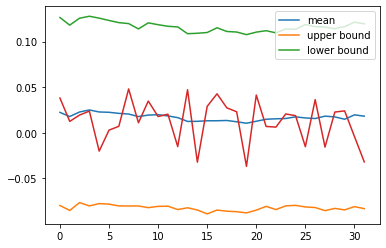

Inference for Stan model: anon_model_fc5e9023446a7c09a4a69d9e4e593d58.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.13  1.5e-3   0.08   -0.03    0.08   0.13   0.18   0.28   2708    1.0
sigma     0.05  5.1e-5 2.7e-3    0.04    0.05   0.05   0.05   0.05   2893    1.0
alpha   8.3e-4  5.8e-5 3.8e-3 -6.6e-3 -1.8e-3 8.7e-4 3.4e-3 8.1e-3   4236    1.0

Samples were drawn using NUTS at Wed Mar 25 18:59:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
----------------------------------------
Time taken: 1.7958s


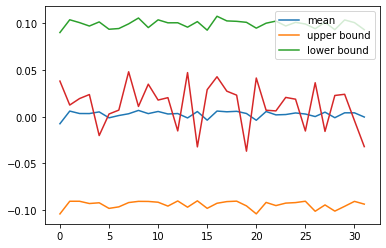

Inference for Stan model: anon_model_fc5e9023446a7c09a4a69d9e4e593d58.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.15  1.3e-3   0.08 -2.2e-3    0.09   0.14    0.2    0.3   3738    1.0
beta[2]  -0.07  1.3e-3   0.08   -0.23   -0.12  -0.07  -0.02   0.07   3751    1.0
sigma     0.05  4.6e-5 2.8e-3    0.04    0.05   0.05   0.05   0.05   3582    1.0
alpha   6.1e-4  5.0e-5 3.8e-3 -6.7e-3 -2.0e-3 6.2e-4 3.2e-3 7.8e-3   5817    1.0

Samples were drawn using NUTS at Wed Mar 25 18:59:59 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
----------------------------------------
Time taken: 2.1055s


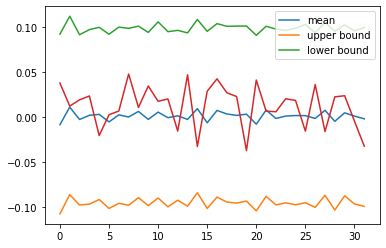

Inference for Stan model: anon_model_841228a7a9e9598d3cf788a74b9801b0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%     25%    50%     75%  97.5%  n_eff   Rhat
beta[1]   -0.03  3.9e-4   0.02  -0.06   -0.04  -0.03   -0.01   0.01   2263    1.0
beta[2]   -0.03  4.9e-4   0.02  -0.08   -0.05  -0.03   -0.02   0.01   2120    1.0
beta[3]  3.7e-3  2.9e-4   0.02  -0.03 -8.2e-3 3.8e-3    0.02   0.04   3537    1.0
beta[4]   -0.01  2.5e-4   0.01  -0.04   -0.02  -0.01 -5.0e-3   0.01   2721    1.0
beta[5]  5.2e-3  1.7e-4 8.6e-3  -0.01 -7.6e-4 5.2e-3    0.01   0.02   2520    1.0
sigma      0.05  4.6e-5 2.7e-3   0.04    0.05   0.05    0.05   0.05   3483    1.0
alpha[1]   0.07  1.6e-3   0.09  -0.09    0.01   0.07    0.13   0.24   3038    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:08 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potentia

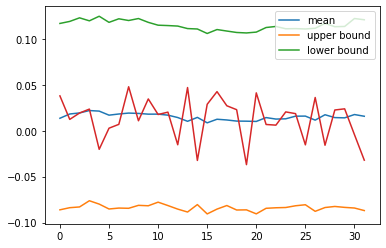

Inference for Stan model: anon_model_841228a7a9e9598d3cf788a74b9801b0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%     25%    50%     75%   97.5%  n_eff   Rhat
beta[1]   -0.04  5.2e-4   0.02  -0.08   -0.06  -0.04   -0.03  3.4e-4   1664    1.0
beta[2]   -0.05  6.0e-4   0.02   -0.1   -0.06  -0.05   -0.03 -3.1e-4   1689    1.0
beta[3]  4.2e-3  2.9e-4   0.02  -0.03 -7.1e-3 4.0e-3    0.02    0.04   3548    1.0
beta[4]   -0.01  2.5e-4   0.01  -0.04   -0.02  -0.01 -6.0e-3    0.01   2795    1.0
beta[5]  4.2e-3  1.6e-4 8.5e-3  -0.01 -1.4e-3 4.2e-3  9.9e-3    0.02   2851    1.0
sigma      0.05  4.8e-5 2.8e-3   0.04    0.05   0.05    0.05    0.05   3423    1.0
alpha[1]   0.07  1.7e-3   0.09   -0.1    0.01   0.07    0.13    0.24   2774    1.0
alpha[2]  -0.16  1.7e-3   0.09  -0.33   -0.22  -0.16    -0.1    0.02   2861    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:19 2020.
For 

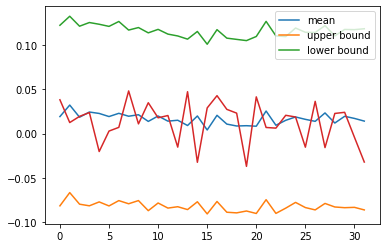

[0.0005763328724434617]
[0.0005763328724434617, 0.0007067701304061475]
[0.0005763328724434617, 0.0007067701304061475, 0.0007791678616138651]
[0.0005763328724434617, 0.0007067701304061475, 0.0007791678616138651, 0.000594911316123556]
[0.0005763328724434617, 0.0007067701304061475, 0.0007791678616138651, 0.000594911316123556, 0.0006399248765654106]


,Models,MSFE,R2OS,R2OS%,p_values,Data outside of 95% interval (%)
0,Bayesian Linear Regression,0.0006,0.1452,14.5152,0.0022,0.0
1,AR lag 1,0.0007,-0.0483,-4.8320,0.7303,0.0
2,AR lag 2,0.0008,-0.1557,-15.5704,0.9649,0.0
3,BLM with AR lag 1,0.0006,0.1176,11.7595,0.0058,0.0
4,BLM with AR lag 2,0.0006,0.0508,5.0829,0.0072,0.0



Model forecasts of blm

------------------------------------------------------------


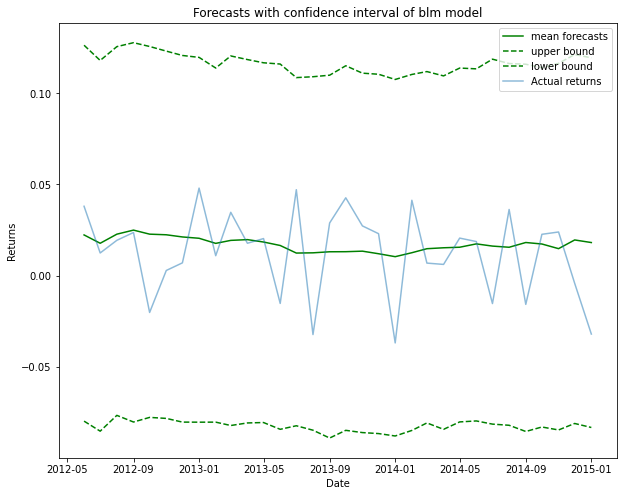


Model forecasts of ar_lag_1

------------------------------------------------------------


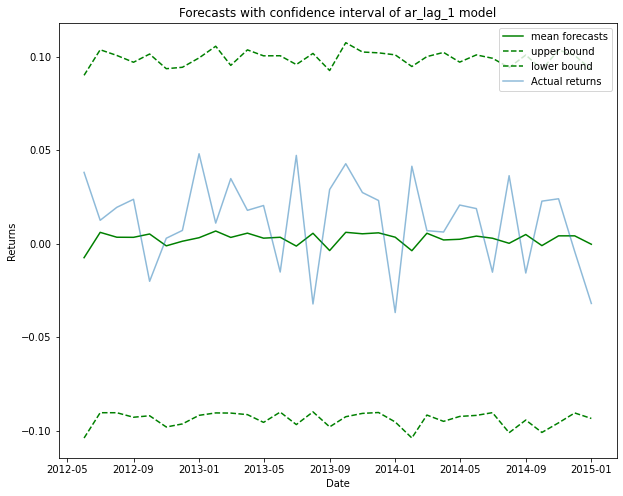


Model forecasts of ar_lag_2

------------------------------------------------------------


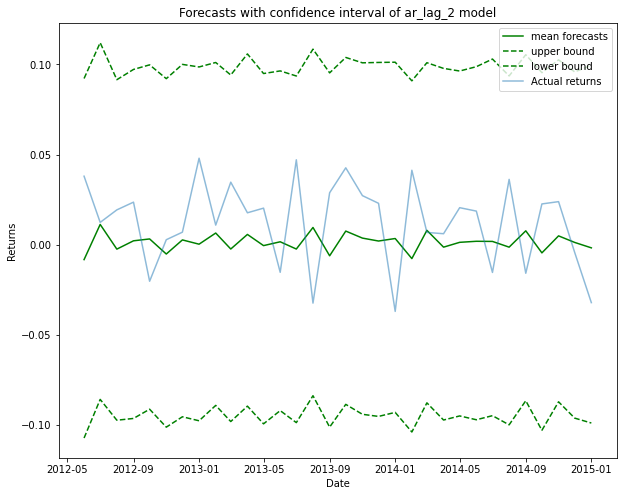


Model forecasts of blm_ar_lag_1

------------------------------------------------------------


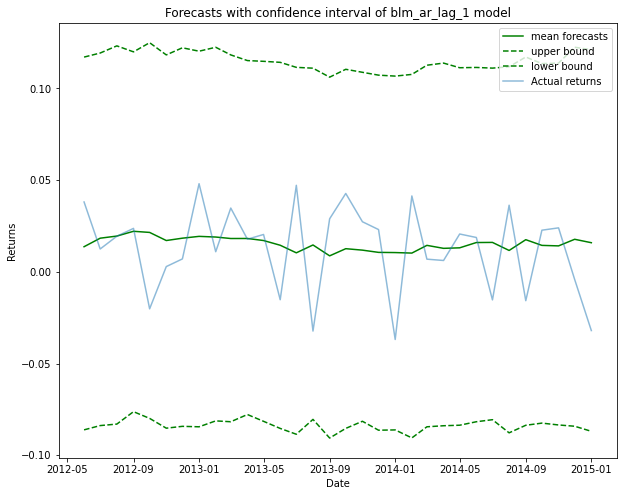


Model forecasts of blm_ar_lag_2

------------------------------------------------------------


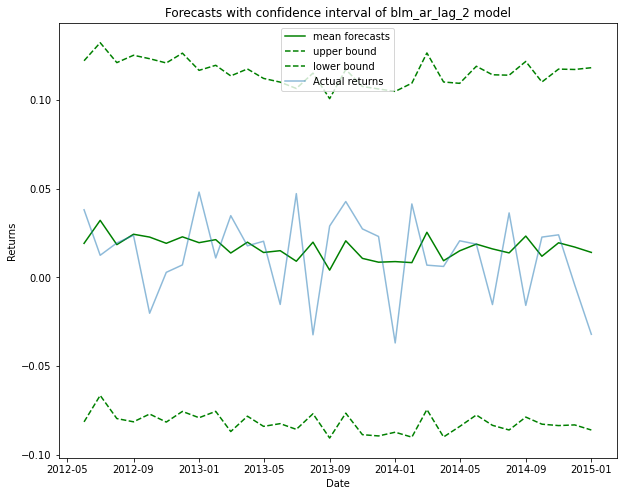

In [26]:
results_nyse_1997 = generate_1997_forecasts('https://raw.githubusercontent.com/nik1997/capstone2020/master/data/nyse_data.csv', verbose=True)

## NEPSE 1997 ->

Shape of dataset:  (211, 8)
Inference for Stan model: anon_model_7143e238289ce76c63fe2853bfec495b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
beta[1]   -0.02  6.2e-4   0.03   -0.08   -0.04   -0.02 -2.5e-3    0.03   2093    1.0
beta[2]   -0.02  6.3e-4   0.03   -0.08   -0.04   -0.02 -5.4e-3    0.03   2130    1.0
beta[3]    0.03  2.6e-4   0.02 -7.0e-3    0.01    0.03    0.04    0.06   3948    1.0
beta[4] -1.4e-3  1.0e-4 6.6e-3   -0.01 -5.9e-3 -1.3e-3  2.8e-3    0.01   4302    1.0
beta[5]   -0.03  2.0e-4   0.01   -0.06   -0.04   -0.03   -0.02 -8.5e-3   4017    1.0
sigma      0.07  6.1e-5 3.7e-3    0.06    0.06    0.07    0.07    0.07   3566    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:26 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split

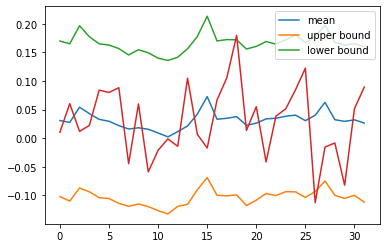

Inference for Stan model: anon_model_fc5e9023446a7c09a4a69d9e4e593d58.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.21  1.4e-3   0.08    0.06   0.15    0.2   0.26   0.36   3028    1.0
sigma     0.07  6.3e-5 3.7e-3    0.06   0.06   0.07   0.07   0.08   3555    1.0
alpha   3.6e-3  8.0e-5 5.2e-3 -6.6e-3 2.1e-4 3.7e-3 7.0e-3   0.01   4150    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:28 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
----------------------------------------
Time taken: 1.8026s


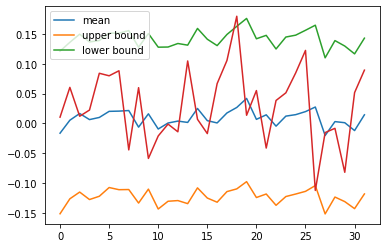

Inference for Stan model: anon_model_fc5e9023446a7c09a4a69d9e4e593d58.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   0.16  1.2e-3   0.08  9.9e-3    0.11   0.16   0.21   0.32   3752    1.0
beta[2]   0.21  1.3e-3   0.08    0.05    0.15   0.21   0.26   0.36   3962    1.0
sigma     0.07  5.8e-5 3.7e-3    0.06    0.06   0.07   0.07   0.07   4000    1.0
alpha   2.9e-3  7.4e-5 5.1e-3 -7.3e-3 -5.5e-4 2.9e-3 6.3e-3   0.01   4797    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:30 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
----------------------------------------
Time taken: 1.9089s


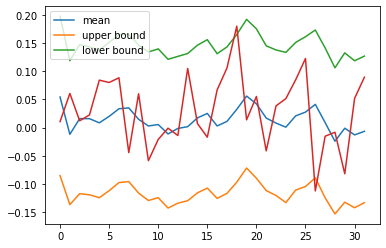

Inference for Stan model: anon_model_841228a7a9e9598d3cf788a74b9801b0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
beta[1]    -0.02  5.1e-4   0.03   -0.07   -0.04   -0.02 -3.5e-3    0.03   2766    1.0
beta[2]    -0.02  5.4e-4   0.03   -0.08   -0.04   -0.02 -5.1e-3    0.03   2693    1.0
beta[3]     0.02  2.5e-4   0.02   -0.01  6.8e-3    0.02    0.03    0.05   4260    1.0
beta[4]  -1.2e-3  9.0e-5 6.7e-3   -0.01 -5.6e-3 -1.4e-3  3.2e-3    0.01   5441    1.0
beta[5]    -0.03  1.8e-4   0.01   -0.05   -0.04   -0.03   -0.02 -3.1e-3   4946    1.0
sigma       0.07  6.3e-5 3.7e-3    0.06    0.06    0.07    0.07    0.07   3474    1.0
alpha[1]    0.15  1.3e-3   0.08 -8.1e-3     0.1    0.15    0.21    0.32   4024    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:39 2020.
For each parameter, n_eff is a crude measure of effective sampl

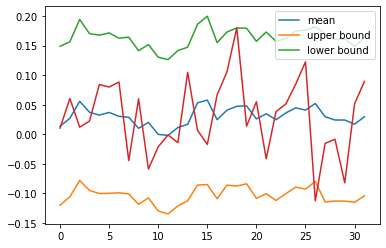

Inference for Stan model: anon_model_841228a7a9e9598d3cf788a74b9801b0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%     25%     50%     75%  97.5%  n_eff   Rhat
beta[1]    -0.02  5.5e-4   0.03  -0.07   -0.04   -0.02 -3.7e-3   0.03   2418    1.0
beta[2]    -0.02  5.6e-4   0.03  -0.08   -0.04   -0.02 -4.7e-3   0.03   2427    1.0
beta[3]     0.02  2.6e-4   0.02  -0.02  4.9e-3    0.02    0.03   0.05   4150    1.0
beta[4]  -6.6e-4  9.5e-5 6.5e-3  -0.01 -5.1e-3 -5.5e-4  3.7e-3   0.01   4694    1.0
beta[5]    -0.02  1.9e-4   0.01  -0.05   -0.03   -0.02   -0.01 3.9e-3   4706    1.0
sigma       0.07  5.8e-5 3.7e-3   0.06    0.06    0.07    0.07   0.07   4042    1.0
alpha[1]    0.13  1.2e-3   0.08  -0.03    0.07    0.13    0.18   0.29   4616    1.0
alpha[2]    0.17  1.2e-3   0.08   0.02    0.12    0.17    0.22   0.33   4016    1.0

Samples were drawn using NUTS at Wed Mar 25 19:00:49 2

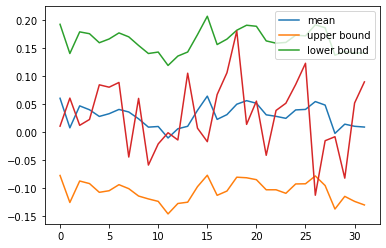

[0.004168668916722695]
[0.004168668916722695, 0.0044067466259679975]
[0.004168668916722695, 0.0044067466259679975, 0.004578512584839853]
[0.004168668916722695, 0.0044067466259679975, 0.004578512584839853, 0.0040035940754222345]
[0.004168668916722695, 0.0044067466259679975, 0.004578512584839853, 0.0040035940754222345, 0.004227295996908498]


,Models,MSFE,R2OS,R2OS%,p_values,Data outside of 95% interval (%)
0,Bayesian Linear Regression,0.0042,0.0852,8.5151,0.0197,6.250
1,AR lag 1,0.0044,0.0329,3.2902,0.1473,6.250
2,AR lag 2,0.0046,-0.0048,-0.4793,0.1980,6.250
3,BLM with AR lag 1,0.0040,0.1214,12.1378,0.0292,6.250
4,BLM with AR lag 2,0.0042,0.0723,7.2284,0.0430,3.125



Model forecasts of blm

------------------------------------------------------------


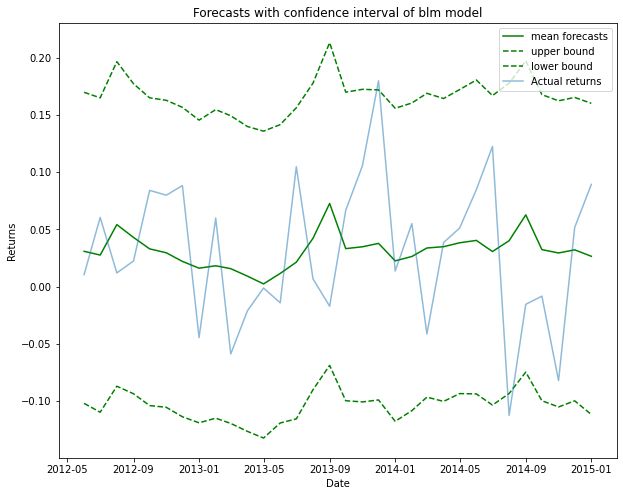


Model forecasts of ar_lag_1

------------------------------------------------------------


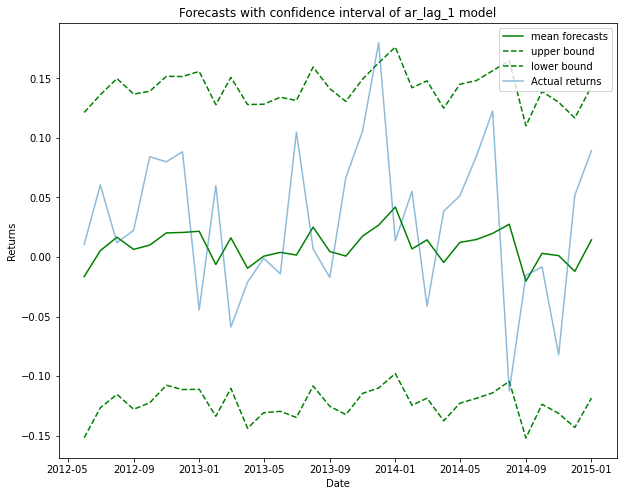


Model forecasts of ar_lag_2

------------------------------------------------------------


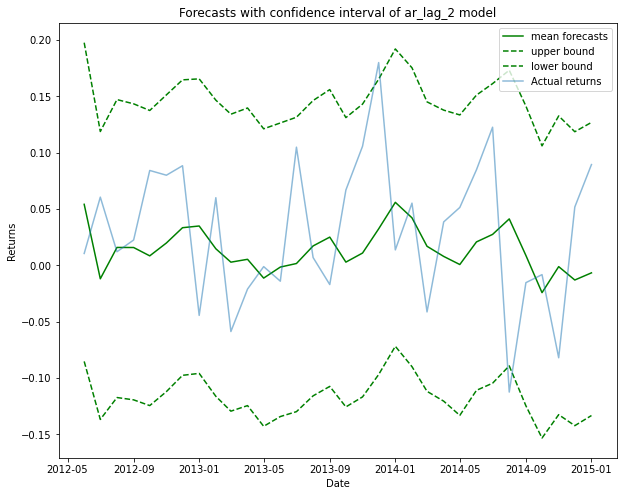


Model forecasts of blm_ar_lag_1

------------------------------------------------------------


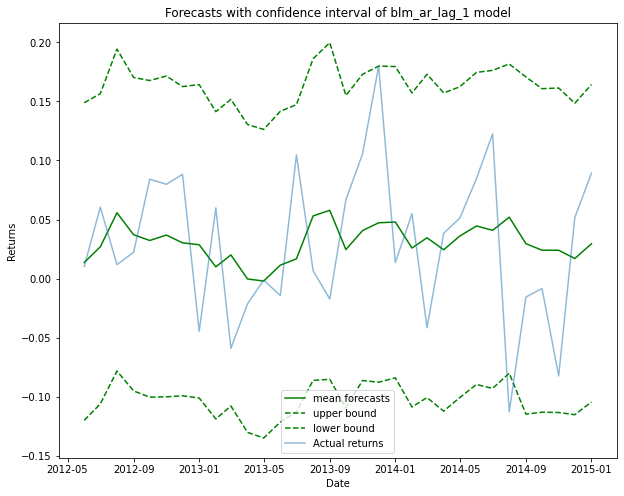


Model forecasts of blm_ar_lag_2

------------------------------------------------------------


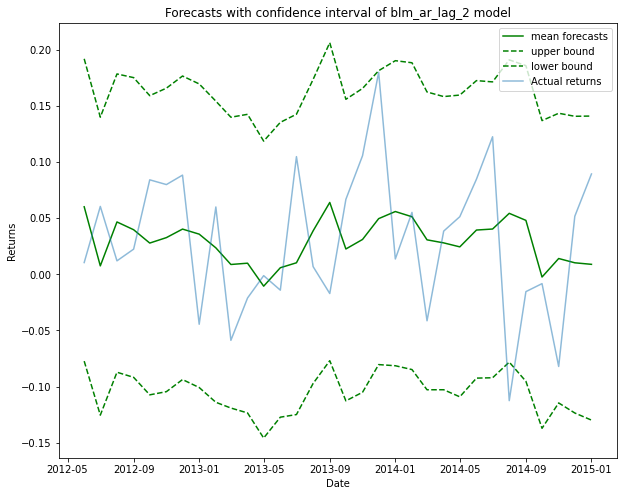

In [27]:
results_nepse_1997 = generate_1997_forecasts('https://raw.githubusercontent.com/nik1997/capstone2020/master/data/nepse_data.csv', verbose=True)